Visualize performance of a domestic vs. foreign asset adjusted for exchange rate
===

In [1]:
import lseg.data as ld
import pandas as pd
import plotly.offline as offline
import plotly.graph_objs as go

In [2]:
ld.open_session()

<lseg.data.session.Definition object at 0x7fb573b19490 {name='codebook'}>

In [3]:
# set notebook mode to allow charts to be generated inline
offline.offline.init_notebook_mode(connected=True)

Define variables


In [4]:
# the two instruments whose performance is to be compared
instr1 = 'TD.TO';
instr2 = 'BARC.L'
# the date range for comparison
start_date = '2022-01-01'
end_date = '2025-05-01'

Get the primary currency in which these instruments trade


In [5]:
data = ld.get_data([instr1, instr2], "TR.CompanyMarketCap.Currency")
# display the trading currencies
data.head()

,Instrument,Currency
0,TD.TO,CAD
1,BARC.L,GBP


Create a currency cross rate RIC with this information, and get timeseries data for this pair

In [6]:
# cross rate ric = curr1curr2=R. It is a calculated metric
crossRIC = data['Currency'][1] + data['Currency'][0] + '=R'
curr = ld.get_history([crossRIC], fields='MID_PRICE', interval='1D', start=start_date, end=end_date)
curr.head()

GBPCAD=R,MID_PRICE
Date,
2022-01-03,1.71685
2022-01-04,1.7194
2022-01-05,1.7292
2022-01-06,1.7228
2022-01-07,1.7184


Get timeseries data for both instruments in the date range

In [7]:
perf1 = ld.get_history(instr1, fields='TRDPRC_1', start=start_date, end=end_date)
perf2 = ld.get_history(instr2, fields='TRDPRC_1', start=start_date, end=end_date)

Scale the performance data for foreign asset with curreny performance

In [8]:
perf1.rename(columns={'TRDPRC_1': 'CLOSE'}, inplace=True)
perf2.rename(columns={'TRDPRC_1': 'CLOSE'}, inplace=True)
curr.rename(columns={'MID_PRICE': 'CLOSE'}, inplace=True)

In [9]:
# create a single DataFrame with both data series (useful if using cufflinks to plot instead of plotly)
perf = pd.concat([perf1, perf2 * curr], axis=1)
perf.columns = [instr1, instr2]
# drop invalid entries from dataframe
perf = perf.dropna()
perf.head()

,TD.TO,BARC.L
Date,,
2022-01-04,99.35,338.137204
2022-01-05,99.95,342.243264
2022-01-06,100.56,345.33526
2022-01-07,100.14,352.7016
2022-01-10,99.73,357.951825


Rebase the data

In [10]:
# rebase both timeseries to 100% at start date
perf_rebase = perf * 100 / (perf[instr1][0], perf[instr2][0])
perf_rebase.head()

,TD.TO,BARC.L
Date,,
2022-01-04,100.0,100.0
2022-01-05,100.603926,101.214318
2022-01-06,101.217916,102.128738
2022-01-07,100.795169,104.307244
2022-01-10,100.382486,105.859935


Create the performance line chart

In [11]:
# using plotly for charting
# create the line chart for both instruments
perfFig = [{
    'x': perf_rebase.index,
    'y': perf_rebase[col],
    'name': col,
    'line': dict( width=1)
}  for col in perf_rebase.columns]


Create the currency spread chart

In [12]:
# create the currency spread chart
dPv = curr['CLOSE'] - curr['CLOSE'][0];
dNv = dPv.copy();
dPv[dPv < 0] = 0.0;
dNv[dNv >= 0] = 0.0;

spreadPv = go.Scatter(
    x=perf_rebase.index,
    y=dPv,
    fill='tozeroy',
    line=dict(
        color='green',
        width=0
    ),
    yaxis='y2',
    name='currency',
    showlegend=False,
);

spreadNv = go.Scatter(
    x=perf_rebase.index,
    y=dNv,
    fill='tozeroy',
    line=dict(
        color='red',
        width=0
    ),
    yaxis='y2',
    name='currency',
    showlegend=False,
);

Plot these charts using plotly

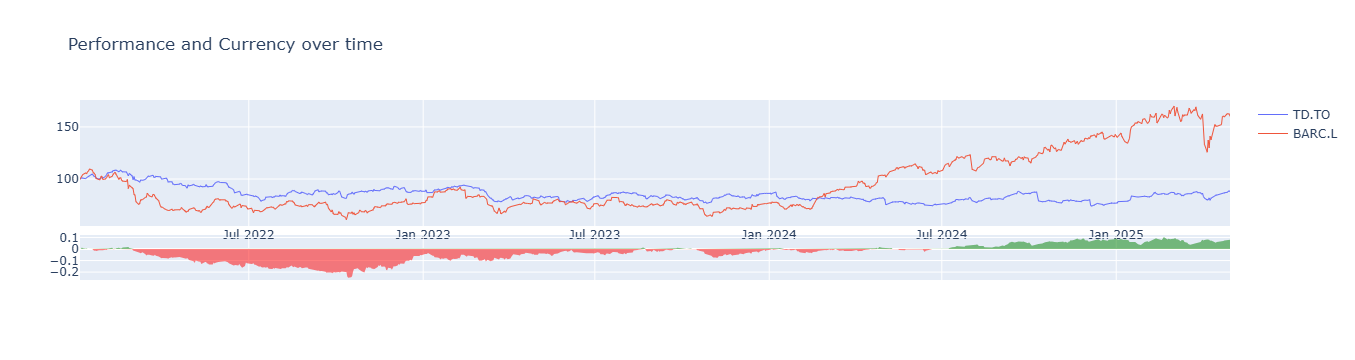

In [13]:
perfFig.append(spreadPv);
perfFig.append(spreadNv);

layout = go.Layout(
    title = 'Performance and Currency over time',
    yaxis1=dict(
        domain=[0.3, 1.0]
    ),    
    yaxis2=dict(
        domain=[0.0, 0.25]
    ),
    xaxis1=dict(
        zerolinecolor='red'
    )
);

# using plotly for charting
fig = go.Figure(data=perfFig, layout=layout)
offline.iplot(fig)

Simplified Code
===
This code achieves the same chart, by utilizing the currency transformation at server side

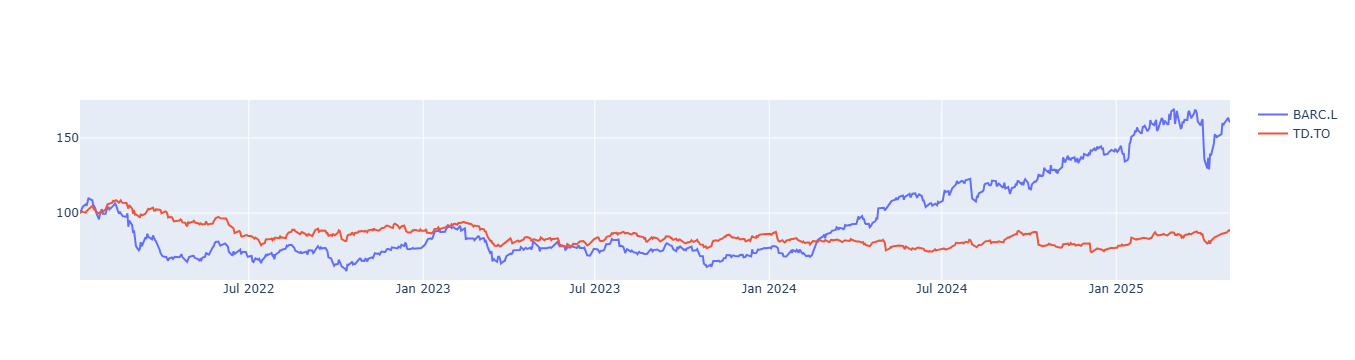

In [32]:
# get and rebase the data
response = ld.get_data([instr1, instr2], fields=['TR.CLOSEPRICE(Curn=CAD)', 'TR.CLOSEPRICE.date'], parameters={'SDate':start_date, 'EDate':end_date, 'Frq':'D'})
df = response.pivot_table(values='Close Price', index=['Date', 'Instrument']).unstack('Instrument').dropna()
rebased = df.apply(lambda series: series/series[0]*100)

# plot it in a chart
offline.iplot([{
    'x': rebased.index,
    'y': rebased[column],
    'name': column[1]
}  for column in rebased.columns])